## Converting dataset into YOLO Format

### Installing all requirements

In [60]:
import os
from pathlib import Path
from tqdm import tqdm
import numpy as np
import xml.etree.ElementTree as ET
import PIL.Image as Image
import cv2
from sklearn.model_selection import train_test_split

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10

np.random.seed(42)

### Image example

In [61]:
# Get tree representation of XML file

mytree = ET.parse("PetsDataset/cat.0.xml")
myroot = mytree.getroot()

In [62]:
# Collect info from XML file
for obj in myroot.findall("object"):
    bndbox = obj.find("bndbox")
    label = obj.find("name").text
    xmin, ymin = bndbox.find("xmin").text, bndbox.find("ymin").text
    xmax, ymax = bndbox.find("xmax").text, bndbox.find("ymax").text


In [63]:
# Image processing
img = Image.open("PetsDataset/cat.0.jpg")
img = img.convert('RGB')

img.save("demo_image.jpeg", "JPEG")

In [64]:
img = cv2.cvtColor(cv2.imread(f'demo_image.jpeg'), cv2.COLOR_BGR2RGB)

img.shape

(374, 500, 3)

In [65]:
# Draw bounding box

cv2.rectangle(
    img,
    (int(xmin), int(ymin)),
    (int(xmax), int(ymax)),
    color = (255, 0, 0),
    thickness=2
)

# get text size
((label_width, label_height), _) = cv2.getTextSize(
        label,
        fontFace=cv2.FONT_HERSHEY_PLAIN,
        fontScale=1.75,
        thickness=2
   )

# draw box for class name
cv2.rectangle(
      img,
      (int(xmin), int(ymin)),
      (int(int(xmin) + label_width + label_width * 0.05), int(int(ymin) + label_height + label_height * 0.25)),
      color=(255, 0, 0),
      thickness=cv2.FILLED
    )

# put class name into box
cv2.putText(
      img,
      label,
      org=(int(xmin), int(int(ymin) + label_height + label_height * 0.25)), # bottom left
      fontFace=cv2.FONT_HERSHEY_PLAIN,
      fontScale=1.75,
      color=(255, 255, 255),
      thickness=2
    )

print("Done")

Done


(-0.5, 499.5, 373.5, -0.5)

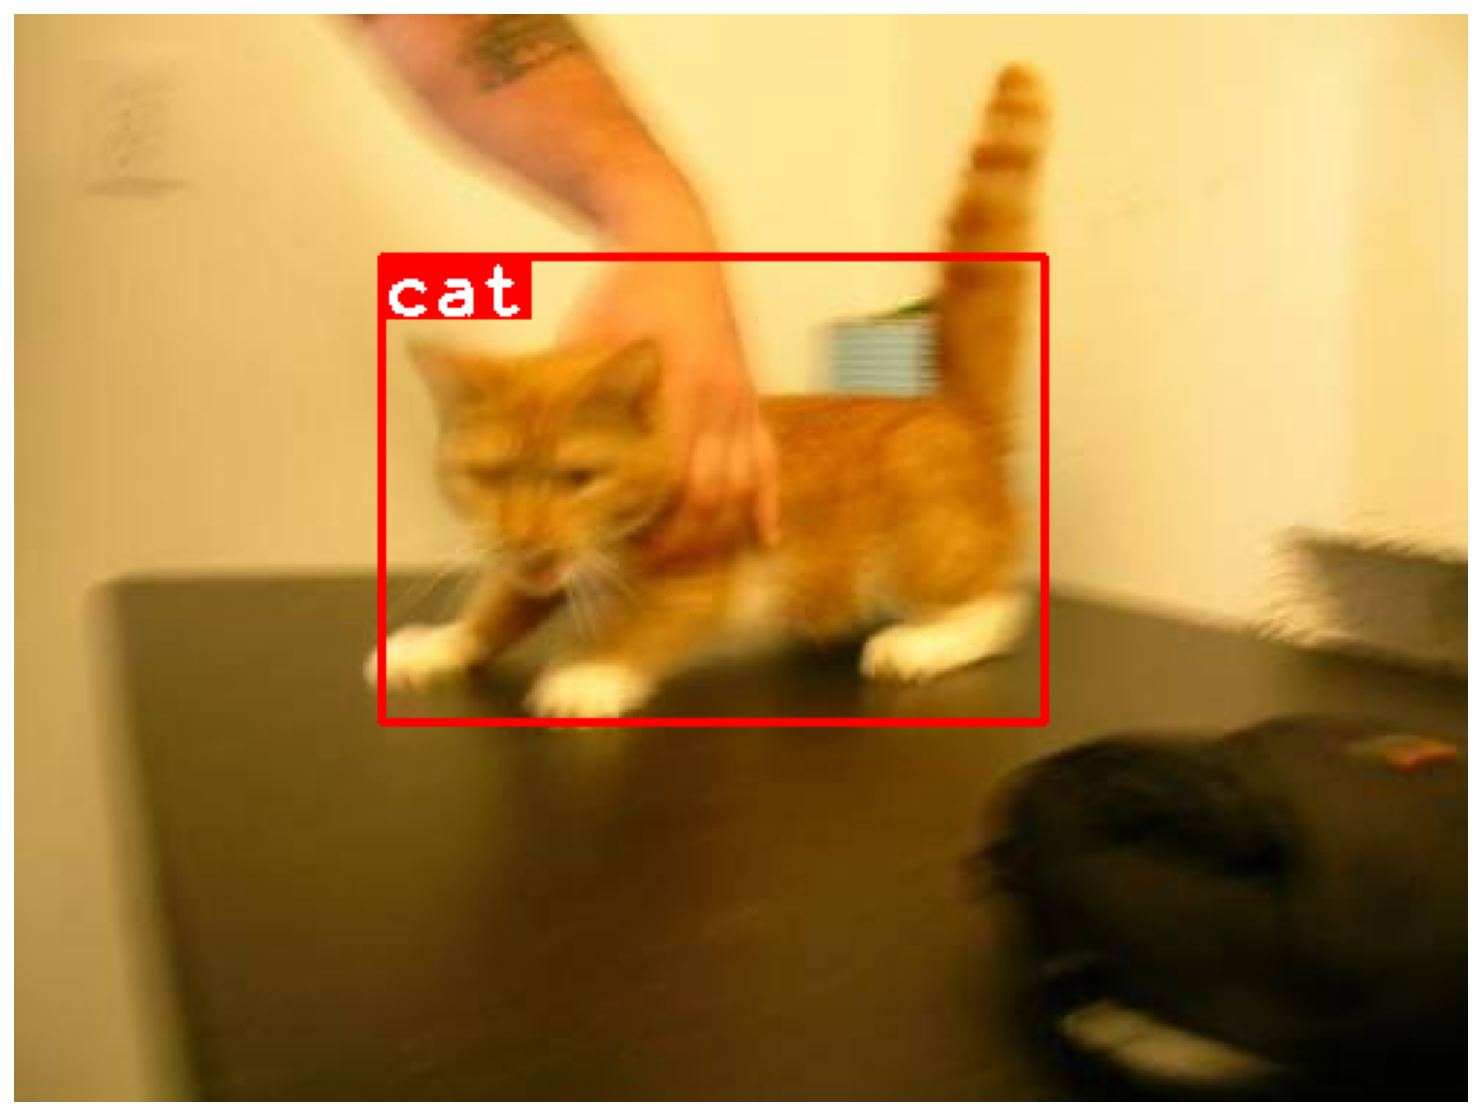

In [66]:
plt.imshow(img)
plt.axis("off")

## Convert dataset into YOLO format

In [67]:
# get all xml files
directory = Path("PetsDataset")
dataset = []

for filename in os.listdir(directory):
    if "xml" in filename:
        dataset.append(filename)

print(len(dataset))

1100


In [68]:
# split dataset
train_dataset, val_dataset = train_test_split(dataset, test_size = 0.1)

len(train_dataset), len(val_dataset)

(990, 110)

In [69]:
# map class to id
class_name_to_id_mapping = {
    "dog": 0,
    "cat": 1
}

In [70]:
# Function that extracts info from xml
def extract_info_from_xml(xml_file):

    # Get tree representation of XML file
    mytree = ET.parse(xml_file)
    myroot = mytree.getroot()

    # Get image info
    img_name = myroot.find("filename").text
    img_size = myroot.find("size")
    img_width, img_height = int(img_size.find("width").text), int(img_size.find("height").text)

    img_info = {
        "name": img_name,
        "width": img_width,
        "height": img_height
    }

    # Get bndboxes info
    bndboxes = []

    for obj in myroot.findall("object"):
        label = obj.find("name").text
        bndbox = obj.find("bndbox")
        xmin, ymin = float(bndbox.find("xmin").text), float(bndbox.find("ymin").text)
        xmax, ymax = float(bndbox.find("xmax").text), float(bndbox.find("ymax").text)

        bndboxes.append({
            "label": label,
            "xmin": xmin,
            "ymin": ymin,
            "xmax": xmax,
            "ymax": ymax
        })

    return img_info, bndboxes

In [71]:
def create_dataset(pets, dataset_type):

    # create images path
    images_path = Path(f"petsYOLO/images/{dataset_type}")
    images_path.mkdir(parents=True, exist_ok=True)

    # create labels path
    labels_path = Path(f"petsYOLO/labels/{dataset_type}")
    labels_path.mkdir(parents=True, exist_ok=True)

    for img_id, row in enumerate(tqdm(pets)):

        image_name = f"{img_id}.jpeg"
        image_info, bndboxes = extract_info_from_xml(Path(f"PetsDataset/{row}"))
        img = Image.open(Path(f"PetsDataset/{image_info['name']}")).convert("RGB")
        img.save(str(images_path/image_name), "JPEG")

        label_name = f"{img_id}.txt"

        with (labels_path / label_name).open(mode="w") as label_file:

            for bbox in bndboxes:

                # get clas; bbox center, width and height
                category_idx = class_name_to_id_mapping[bbox["label"]]
                bbox_width = bbox["xmax"] - bbox["xmin"]
                bbox_height = bbox["ymax"] - bbox["ymin"]
                bbox_x_center = (bbox["xmin"] + bbox["xmax"]) / 2
                bbox_y_center = (bbox["ymin"] + bbox["ymax"]) / 2

                # Normalize coordinates
                bbox_x_center, bbox_width = (bbox_x_center / image_info["width"]), (bbox_width / image_info["width"])

                bbox_y_center, bbox_height = (bbox_y_center / image_info["height"]), (bbox_height / image_info["height"])

                label_file.write(
                    f"{category_idx} {bbox_x_center} {bbox_y_center} {bbox_width} {bbox_height}\n"
                )

In [72]:
create_dataset(train_dataset, "train")
create_dataset(val_dataset, "val")

100%|██████████| 110/110 [00:00<00:00, 121.05it/s]
